In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the val set same as training set without augmentation
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


In [2]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=8, shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_val)
valloader = torch.utils.data.DataLoader(
    valset, batch_size=8, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


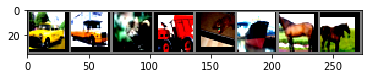

  car truck   cat truck   dog  ship horse horse


In [3]:

########################################################################
# Let us show some of the training images, for fun.


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))


In [7]:
import torch
import torch.nn as nn


class CNN(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            #nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #n.Dropout2d(p=0.05),
            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            #n.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            #n.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

net = CNN()
net.cuda()
from torchsummary import summary
print(summary(net, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [5]:

import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [6]:
from torch.autograd import Variable
import os


"""Define evaluation metric

We will use accuracy as an evaluation metric
"""

def calculate_accuracy(loader):
  total = 0
  correct = 0
  
  with torch.no_grad():
    for data in loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  return 100 * correct / total   




start_epoch = 0
epochs = 50

for epoch in range(start_epoch, epochs + start_epoch):

    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data   
        inputs = inputs.cuda()
        labels = labels.cuda()
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)
    # Calculate training/test set accuracy of the existing model
    train_accuracy = calculate_accuracy(trainloader)
    net.eval()
    val_accuracy = calculate_accuracy(valloader)

    print("Epoch: {0} | Loss: {1} | Training accuracy: {2}% | Validation accuracy: {3}%".format(epoch+1, 
                                                            running_loss, train_accuracy, val_accuracy))

   


Epoch: 1 | Loss: 2.1625452963638305 | Training accuracy: 29.726% | Validation accuracy: 31.92%
Epoch: 2 | Loss: 1.6952117272377014 | Training accuracy: 44.216% | Validation accuracy: 45.66%
Epoch: 3 | Loss: 1.4086232169103623 | Training accuracy: 54.47% | Validation accuracy: 58.49%
Epoch: 4 | Loss: 1.1659955555009842 | Training accuracy: 61.67% | Validation accuracy: 63.36%
Epoch: 5 | Loss: 0.9744830398821831 | Training accuracy: 69.158% | Validation accuracy: 70.78%
Epoch: 6 | Loss: 0.8218051487731933 | Training accuracy: 72.86% | Validation accuracy: 73.76%
Epoch: 7 | Loss: 0.7196430156731606 | Training accuracy: 74.888% | Validation accuracy: 76.28%
Epoch: 8 | Loss: 0.6445599976444244 | Training accuracy: 80.528% | Validation accuracy: 80.08%
Epoch: 9 | Loss: 0.5855336569404602 | Training accuracy: 80.926% | Validation accuracy: 80.55%
Epoch: 10 | Loss: 0.5352807063364983 | Training accuracy: 83.144% | Validation accuracy: 82.24%
Epoch: 11 | Loss: 0.4916138747048378 | Training accu